In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"; 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [2]:
import numpy as np
import keras
import cv2 as cv
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [3]:
from models.SegNet import seg_net
from models.segnet_seq import SegNet
from keras.preprocessing.image import load_img
from keras.utils.np_utils import to_categorical  
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

In [4]:
import keras.backend as K
from keras.applications import vgg16

In [5]:
import tensorflow as tf
#tf.enable_eager_execution()

In [6]:
labels = os.listdir('masks')

In [7]:
from utilities import *

In [8]:
def generateData( labels , batch_size = 1 , train_path = './_train/',
                train_label_path = './masks/', img_w = 256, img_h = 256, n_classes = 47):  

    while True:  
        train_data = []  
        train_label = []  
        batch = 0  
        for i in (range(len(labels))): 
            uri = labels[i]
            batch += 1 
            img = load_image(replace_ext(train_path + uri) , shape=(img_w, img_h))
            train_data.append(img)  
            mask = load_image(train_label_path + uri, True, shape=(img_w, img_h))
            mask = mask.reshape((img_w * img_h,))  
            train_label.append(mask)  
            
            
            if batch % batch_size == 0: 
                train_data = np.array(train_data)  
                #weights = get_weights(np.array(train_label))
                train_label = np.array(train_label).flatten()
                train_label = to_categorical(train_label, num_classes= n_classes)  
                train_label = train_label.reshape( ( batch_size, img_w , img_h , n_classes ) )  
                yield (train_data,train_label)
                train_data = []  
                train_label = []  
                batch = 0  

In [9]:
def testing_data_generator(labels , batch_size=3, shape=(256,256)):
    calls = 2
    counter = 1
    batch  = generateData(labels , batch_size)
    for original , masks in batch:
        print("New step.....")
        print(original.shape , masks.shape)
        
        fig, ax = plt.subplots(batch_size , 2)
        
        for idx in range(batch_size):
            ax[idx, 0].imshow(original[idx])
            ax[idx, 1].imshow( masks[idx].argmax(-1))
        
        if counter == calls:
            break #breaking generator infinite loop needed by keras
        counter += 1
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


New step.....
(3, 256, 256, 3) (3, 256, 256, 47)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


New step.....
(3, 256, 256, 3) (3, 256, 256, 47)


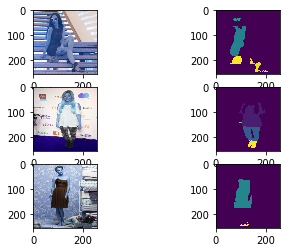

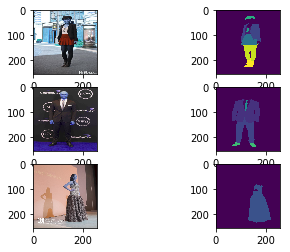

In [10]:
testing_data_generator(labels)

In [37]:
def predict_batch_images(number_of_images, model, labels, path_train = None, path_mask = None , max_image = 45625 ,
                        shape = (256,256,3)):
    if path_train == None:
        path_train = "_train" + os.sep 
    
    if path_mask == None:
        path_mask = 'masks' + os.sep
    
    random_numbers = np.random.randint(max_image, size=(number_of_images))
    
    batch_prediction  = np.zeros( (number_of_images,) + shape)
    real_masks = np.zeros((number_of_images , shape[0],  shape[1]))
   
    for idx , random in enumerate(random_numbers):
        batch_prediction[idx] = load_image(path_train + replace_ext(labels[random]))
        real_masks[idx] = load_image( path_mask + labels[random] , mask=True)
    
    batch_prediction = model.predict(batch_prediction)
    fig, ax = plt.subplots( 2 , number_of_images)
    
    for idx in range(number_of_images):
            ax[0 , idx].imshow(real_masks[idx])
            ax[1 , idx].imshow(batch_prediction[idx].argmax(-1))
    
    
    return batch_prediction , real_masks

In [12]:
def lets_train(model, _from_train , _to_train , batch_size, steps_per_epoch , _from_val, to_val, validation_steps, epochs, callbacks,
              shape=(224,224)):
    history = model.fit_generator(generateData(labels[_from_train:_to_train] , 
                                               batch_size = batch_size , 
                                               img_w = shape[0],
                                               img_h = shape[1]),
                    steps_per_epoch= steps_per_epoch,
                    validation_data= generateData(labels[_from_val:to_val]),
                    validation_steps= validation_steps,
                    epochs = epochs,
                    callbacks = callbacks)
    return history

In [13]:
def get_callbacks(model_name):
    csv_logger = CSVLogger(model_name + 'training.log')
    check_point = ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}'+ model_name + '.hdf5')
    return [csv_logger, check_point]

In [14]:
segnet_model = seg_net((256,256,3))

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
#optimizer = Adam(lr=0.004)
segnet_model.compile(loss='categorical_crossentropy' ,optimizer='adam',metrics=['accuracy' , i_over_u ])
segnet_model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
__________

In [16]:
history = lets_train(model = segnet_model, 
                     _from_train=0, 
                     _to_train=1, 
                     batch_size=1, 
                     steps_per_epoch=1, 
                     validation_steps=1, 
                     _from_val=0, to_val=1, 
                     epochs = 3, 
                     shape = (256,256),
                     callbacks = None)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/3
1/1 [==============================] - 11s 11s/step - loss: 4.3873 - acc: 0.0275 - i_over_u: 0.1083 - val_loss: 14.9451 - val_acc: 0.0728 - val_i_over_u: 0.1084
Epoch 2/3
1/1 [==============================] - 0s 417ms/step - loss: 4.1134 - acc: 0.1305 - i_over_u: 0.1193 - val_loss: 14.9452 - val_acc: 0.0728 - val_i_over_u: 0.1084
Epoch 3/3
1/1 [==============================] - 0s 395ms/step - loss: 3.5136 - acc: 0.2430 - i_over_u: 0.1288 - val_loss: 14.9452 - val_acc: 0.0728 - val_i_over_u: 0.1084


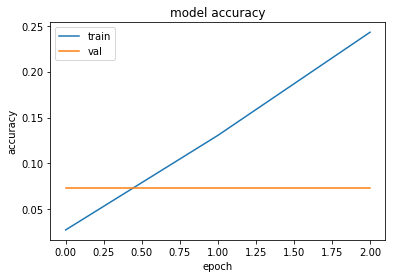

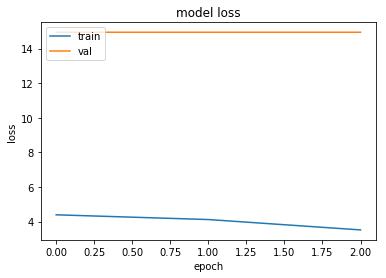

In [17]:
draw_results(history)

In [18]:
from models.Unet import Unet

In [19]:
unet_model = Unet(n_label=47, input_size=(256,256,3))
unet_model = unet_model.get_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/hcastro/moda_dataset/models/Unet.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  self.model = Model(input = inputs, output = activated)


In [24]:
unet_model.compile(loss='categorical_crossentropy' ,optimizer='adam',metrics=['accuracy' , i_over_u] )  

In [25]:
history = lets_train(model = unet_model, 
                     _from_train=0, 
                     _to_train=1, 
                     batch_size=1, 
                     steps_per_epoch=1, 
                     validation_steps=1, 
                     _from_val=0, to_val=1, 
                     epochs = 3, 
                     shape = (256,256),
                     callbacks = None)

Epoch 1/3
1/1 [==============================] - 5s 5s/step - loss: 1.1921e-07 - acc: 0.8916 - i_over_u: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.8916 - val_i_over_u: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 357ms/step - loss: 1.1921e-07 - acc: 0.8916 - i_over_u: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.8916 - val_i_over_u: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 0s 341ms/step - loss: 1.1921e-07 - acc: 0.8916 - i_over_u: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.8916 - val_i_over_u: 0.0000e+00


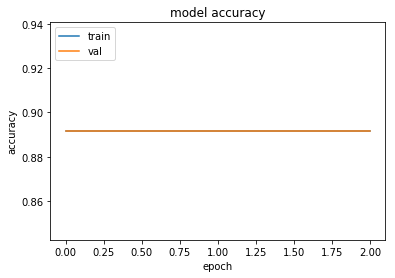

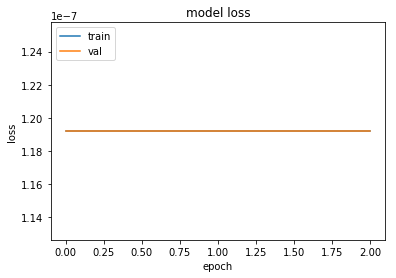

In [27]:
draw_results(history)

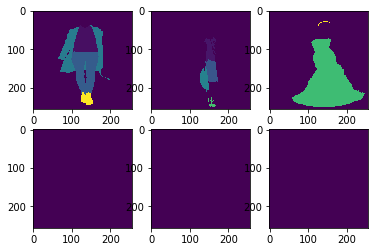

In [39]:
_, _ = predict_batch_images(model = unet_model ,labels=labels, number_of_images=3)

# Transfer Learning

In [12]:
model =  vgg16.VGG16(include_top=False , weights='imagenet')

In [40]:
import sys
sys.path.insert(0, 'models/')

In [41]:
from models.FCN import *
from models.utils.loss_function import softmax_sparse_crossentropy_ignoring_last_label

In [42]:
atrous_resnet50_model = AtrousFCN_Resnet50_16s(input_shape=(256,256,3) , classes=47)

In [43]:
atrous_resnet50_model.compile(loss='categorical_crossentropy' ,optimizer='sgd',metrics=['accuracy'])

In [44]:
atrous_resnet50_model.load_weights('AtrousFCN_Resnet50_16s.h5')

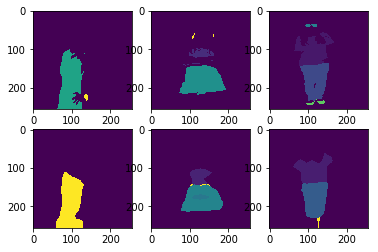

In [45]:
_, _ = predict_batch_images(model = atrous_resnet50_model ,labels=labels, number_of_images=3)

In [ ]:
history = lets_train(model = atrous_resnet50_model, 
                     _from_train=0, 
                     _to_train=38000, 
                     batch_size=20, 
                     steps_per_epoch=1600, 
                     validation_steps=3500, 
                     _from_val=38000, to_val=45000, 
                     epochs = 5, 
                     callbacks = get_callbacks('atrous_resnet50'))

Epoch 1/5
1600/1600 [==============================] - 7881s 5s/step - loss: 0.4565 - acc: 0.8699 - val_loss: 0.3594 - val_acc: 0.8904
Epoch 2/5
 441/1600 [=======>......................] - ETA: 1:23:46 - loss: 0.3555 - acc: 0.8912

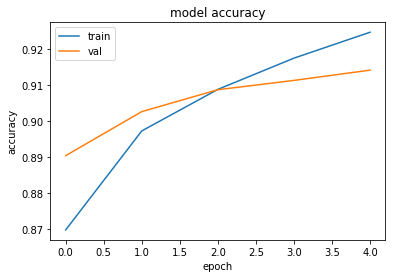

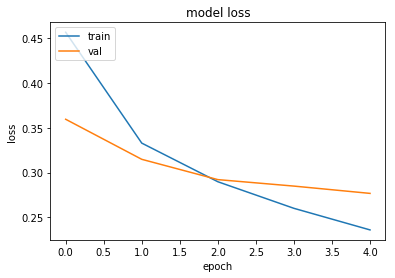

In [97]:
draw_results(history)

In [46]:
model_fcn_resnet50 = FCN_Resnet50_32s(input_shape=(256,256,3) , classes=47)

In [47]:
model_fcn_resnet50.compile(loss='categorical_crossentropy' ,optimizer='sgd',metrics=['accuracy' , i_over_u ])

In [49]:
history = lets_train(model = model_fcn_resnet50, 
                    _from_train=0, 
                     _to_train=30, 
                     batch_size=30, 
                     steps_per_epoch=1, 
                     validation_steps=1, 
                     _from_val=30, to_val=60, 
                     epochs = 10,
                     shape=(256,256),
                     callbacks = None)


Epoch 1/10
1/1 [==============================] - 22s 22s/step - loss: 7.6105 - acc: 0.0750 - i_over_u: 0.1907 - val_loss: 11.3519 - val_acc: 0.6140 - val_i_over_u: 0.2653
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 8.5439 - acc: 0.3071 - i_over_u: 0.2209 - val_loss: 12.6219 - val_acc: 0.4973 - val_i_over_u: 0.3147
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 9.5790 - acc: 0.1718 - i_over_u: 0.1975 - val_loss: 15.1798 - val_acc: 0.3880 - val_i_over_u: 0.1115
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 7.2541 - acc: 0.0833 - i_over_u: 0.2020 - val_loss: 4.5685 - val_acc: 0.0000e+00 - val_i_over_u: 0.0644
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 3.7125 - acc: 0.0178 - i_over_u: 0.1942 - val_loss: 4.2389 - val_acc: 0.0000e+00 - val_i_over_u: 0.0573
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 4.7398 - acc: 0.0137 - i_over_u: 0.1934 - val_loss: 8.6068 - val_acc: 0.0

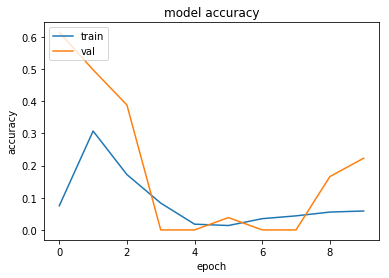

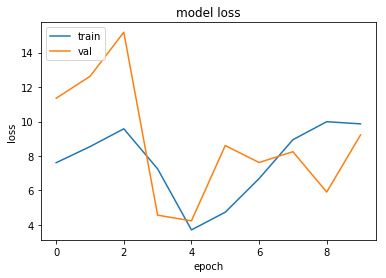

In [50]:
draw_results(history)

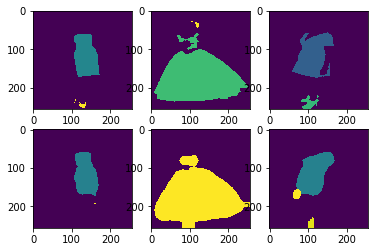

In [51]:
_, _ = predict_batch_images(model = atrous_resnet50_model ,labels=labels, number_of_images=3,  )